In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Wczytanie danych i podział względem modelu i rodzaju klastru

In [12]:
raw_results = pd.read_csv('results.csv').drop(['group'], axis=1)
averaged = raw_results.groupby(['cluster','model','library','spark-executors']).mean().reset_index()

xgb_results = averaged[averaged.model == 'GBT'].drop(['model'], axis=1)
lr_results = averaged[averaged.model == 'LR'].drop(['model'], axis=1)


dataproc_xgb_results = xgb_results[xgb_results.cluster == 'dataproc'].drop(['cluster'], axis=1)
k8s_xgb_results = xgb_results[xgb_results.cluster == 'k8s'].drop(['cluster'], axis=1)

dataproc_lr_results = lr_results[lr_results.cluster == 'dataproc'].drop(['cluster'], axis=1)
k8s_lr_results = lr_results[lr_results.cluster == 'k8s'].drop(['cluster'], axis=1)

### Przygotowanie danych pod wizualizację

In [13]:
# 

def convert_libs_to_seperate_columns_xgb(df):
    executor_counts = [1,2,6,8]
    rows = []
    for e_c in executor_counts:
        h20_time        = df[(df['library'] == 'h20') & (df['spark-executors'] == e_c)]['elapsed-time'].iloc[0]
        spark_ml_time   = df[(df['library'] == 'spark-ml') & (df['spark-executors'] == e_c)]['elapsed-time'].iloc[0]
        synapse_ml_time = df[(df['library'] == 'synapse-ml') & (df['spark-executors'] == e_c)]['elapsed-time'].iloc[0]
                                                                                               
        new_row = {'spark-executors': e_c, 'h20': h20_time, 'spark-ml': spark_ml_time, 'synapse-ml':synapse_ml_time, 
                   'avg': (h20_time + spark_ml_time + synapse_ml_time) / 3}
        rows.append(new_row)
    return pd.DataFrame(rows)

dataproc_xgb_results = convert_libs_to_seperate_columns_xgb(dataproc_xgb_results)
k8s_xgb_results = convert_libs_to_seperate_columns_xgb(k8s_xgb_results)

def convert_libs_to_seperate_columns_lr(df):
    executor_counts = [1,2,6,8]
    rows = []
    for e_c in executor_counts:
        h20_time        = df[(df['library'] == 'h20') & (df['spark-executors'] == e_c)]['elapsed-time'].iloc[0]
        spark_ml_time   = df[(df['library'] == 'spark-ml') & (df['spark-executors'] == e_c)]['elapsed-time'].iloc[0]
                                                                                               
        new_row = {'spark-executors': e_c, 'h20': h20_time, 'spark-ml': spark_ml_time, 
                   'avg': (h20_time + spark_ml_time) / 2}
        rows.append(new_row)
    return pd.DataFrame(rows)

dataproc_lr_results = convert_libs_to_seperate_columns_lr(dataproc_lr_results)
k8s_lr_results = convert_libs_to_seperate_columns_lr(k8s_lr_results)

### Porównanie rozproszonych implementacji GBT

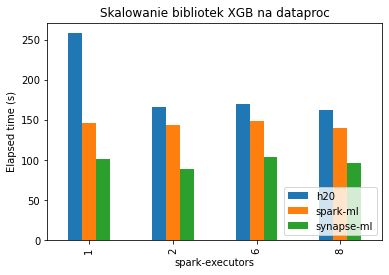

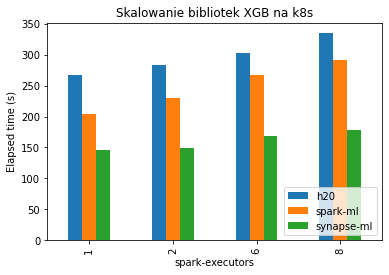

In [16]:
_ = dataproc_xgb_results.drop(["avg"], axis=1).plot.bar(x='spark-executors', title='Skalowanie imlementacji GBT na dataproc')
_ = plt.legend(loc='lower right')
_ = plt.ylabel("Elapsed time (s)")
_ = k8s_xgb_results.drop(["avg"], axis=1).plot.bar(x='spark-executors', title='Skalowanie imlementacji GBT na k8s')
_ = plt.legend(loc='lower right')
_ = plt.ylabel("Elapsed time (s)")

### Porównanie rozproszonych implementacji LR 
Sklearnowa z etapu 2. nie jest rozproszona więc jej nie uwzględniamy

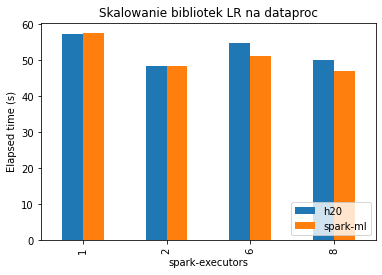

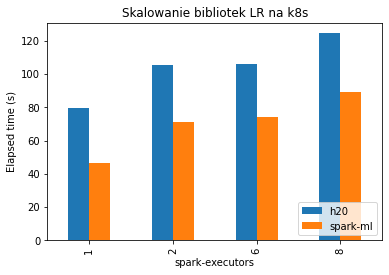

In [18]:
_ = dataproc_lr_results.drop(["avg"], axis=1).plot.bar(x='spark-executors', title='Skalowanie imlementacji LR na dataproc')
_ = plt.legend(loc='lower right')
_ = plt.ylabel("Elapsed time (s)")
_ = k8s_lr_results.drop(["avg"], axis=1).plot.bar(x='spark-executors', title='Skalowanie imlementacji LR na k8s')
_ = plt.ylabel("Elapsed time (s)")
_ = plt.legend(loc='lower right')

### Porównanie klastrów k8s i dataproc
Uśredniamy wyniki wszystkich implementacji

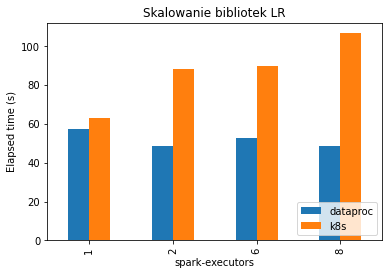

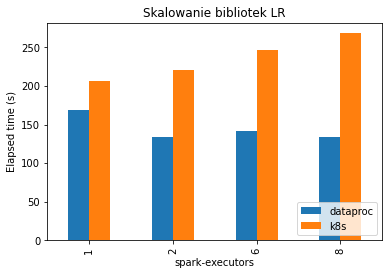

In [21]:
cluster_df_lr = pd.concat([dataproc_lr_results['spark-executors'], dataproc_lr_results['avg'], k8s_lr_results['avg']],
                       axis=1, keys=['spark-executors','dataproc', 'k8s'])
_ = cluster_df_lr.plot.bar(x='spark-executors', title='Skalowanie imlementacji LR')
_ = plt.ylabel("Elapsed time (s)")
_ = plt.legend(loc='lower right')

cluster_df_xgb = pd.concat([dataproc_xgb_results['spark-executors'], dataproc_xgb_results['avg'], k8s_xgb_results['avg']],
                       axis=1, keys=['spark-executors','dataproc', 'k8s'])
_ = cluster_df_xgb.plot.bar(x='spark-executors', title='Skalowanie imlementacji GBT')
_ = plt.ylabel("Elapsed time (s)")
_ = plt.legend(loc='lower right')


## Omówienie wyników

- Nie obserwujemy dużego przyspieszenia czasu uczenia modeli wraz ze wzrostem liczby executorów sparkowych. Zyski z rozposzenia otrzymujemy jedynie na klastrze dataproc - w większości przypadków najszybciej wypada użycie 2 executorów.
- Dla modeli typu GBT zdecydowanie najwydajniejsza implementacja jest z biblioteki SynapseML - różnica względem lokalnych obliczeń z etapu 2, gdzie to SparkML był najszybszy. H2O, tak samo jak w etapie 2 wypada najwolniej.
- Dziwi nas, że korzystania z 6 zadeklarowanych w terraformie fizycznych maszyn, to optymalną liczbą egzekutorów nie jest 6, a 2. Co więcej, 8 egzekutorów wypada lepiej niż 6 w większości przypadków.
- Na klastrze k8s czas wykonania znacząco wzrasta zamiast spadać, gdy mocniej rozpraszamy obliczenia. Możemy się tylko domyślać, że jest to spowodowane Kubernetesowymi narzutami na synchronizację danych z wielu Podów. Dataproc z kolei jest zaprojektowany specjalnie pod rozproszone obliczenia sparkowe, dlatego wypada znacznie lepiej w porównaniu tych dwóch serwisów do zarządzania klastrami.